In [54]:
import pyhf
import numpy as np
import matplotlib.pyplot as plt
import pyhf.contrib.viz.brazil
from pyhf.infer.calculators import AsymptoticCalculator
import scipy.stats

plt.rcParams['savefig.facecolor'] = 'white'


def gpdf(qq, muprime, sig, mu):
    cut = mu ** 2 / sig ** 2

    # 1/√(2π)
    standard_pre = 1 / np.sqrt(2 * np.pi)

    # compute the arg of the exponential
    muprime_muhat1_minus_over_sig = (
        qq - (mu ** 2 / sig ** 2 - (2 * mu * muprime / sig ** 2))
    ) / (2 * mu / sig)
    muprime_muhat2_minus_over_sig = np.sqrt(qq) - (mu - muprime) / sig

    # chose which one
    muhat_over_sig = np.where(
        qq > cut, muprime_muhat1_minus_over_sig, muprime_muhat2_minus_over_sig
    )

    # exp(-0.5 (mu^-mu'))
    arg = -0.5 * (muhat_over_sig) ** 2

    # compute the jacobian
    # 1/ sigma * dµ^/dq
    oos_j1 = 1 / (2 * mu / sig)
    oos_j2 = 1 / (2 * np.sqrt(qq))

    # chose which one
    one_over_sig_jacobian = np.where(qq > cut, oos_j1, oos_j2)

    # compute the reparametrized gaussian
    return standard_pre * np.exp(arg) * one_over_sig_jacobian


def testrail_parab(muhat, mu, sigma):
    return (muhat - mu) ** 2 / sigma ** 2


def testrail_flat(muhat, mu, sigma):
    return np.where(
        muhat < 0,
        (muhat - mu) ** 2 / sigma ** 2 - muhat ** 2 / sigma ** 2,
        np.where(muhat < mu, (muhat - mu) ** 2 / sigma ** 2, 0.0),
    )


def get_toy_results(test_poi, toys):
    qmu_tilde = np.asarray(
        [
            pyhf.infer.test_statistics.qmu_tilde(
                test_poi,
                toy,
                model,
                init_pars=model.config.suggested_init(),
                par_bounds=model.config.suggested_bounds(),
                fixed_params=model.config.suggested_fixed(),
            )
            for toy in toys
        ]
    )

    unbounded_bounds = model.config.suggested_bounds()
    unbounded_bounds[model.config.poi_index] = (-10, 10)
    pars = np.asarray(
        [pyhf.infer.mle.fit(toy, model, par_bounds=unbounded_bounds) for toy in toys]
    )

    muhat = pars[:, model.config.poi_index]
    return muhat, qmu_tilde


model = pyhf.simplemodels.hepdata_like(
    signal_data=[30.0], bkg_data=[50.0], bkg_uncerts=[7.0]
)
data = [55.0] + model.config.auxdata

asimov_data = pyhf.infer.calculators.generate_asimov_data(
    0.0,
    data,
    model,
    model.config.suggested_init(),
    model.config.suggested_bounds(),
    model.config.suggested_fixed(),
)

In [40]:
muhatmin, muhatmax = -5, 5
mumin, mumax = 1e-2, 1.2
maxsigma = 4

qqspan = np.linspace(0, maxsigma ** 2, 10001)
muspan = np.linspace(mumin, mumax, 31)
muhatspan = np.linspace(muhatmin, muhatmax, 1001)
test_stats = []
vals = []
prll_and_sigmas = []


def collect_data_at_test(mu_test):
    calc = AsymptoticCalculator(data, model)
    ts = calc.teststatistic(mu_test)
    ds, db = calc.distributions(mu_test)
    cl_sb, cl_b, cl_s = calc.pvalues(ts, ds, db)

    obs_pllr_ts = pyhf.infer.test_statistics.qmu_tilde(
        mu_test,
        data,
        model,
        model.config.suggested_init(),
        model.config.suggested_bounds(),
        model.config.suggested_fixed(),
    )

    asimov_pllr_ts = pyhf.infer.test_statistics.qmu_tilde(
        mu_test,
        asimov_data,
        model,
        model.config.suggested_init(),
        model.config.suggested_bounds(),
        model.config.suggested_fixed(),
    )
    sigma = np.sqrt(mu_test ** 2 / asimov_pllr_ts)

    tstats = [ds.shift, db.shift, ts]
    pvals = [cl_sb, cl_b, cl_s]
    prll_and_sig = [obs_pllr_ts, asimov_pllr_ts, sigma]
    return tstats, pvals, prll_and_sig


for mu_test in muspan:
    tstats, pvals, prll_and_sig = collect_data_at_test(mu_test)
    test_stats.append(tstats)
    vals.append(pvals)
    prll_and_sigmas.append(prll_and_sig)

vals = np.array(vals)
test_stats = np.array(test_stats)
prll_and_sigmas = np.array(prll_and_sigmas)

unbounded_bounds = model.config.suggested_bounds()
unbounded_bounds[model.config.poi_index] = (-10, 10)

empirial_muhat = pyhf.infer.mle.fit(data, model, par_bounds=unbounded_bounds)[
    model.config.poi_index
]


def getv(mu_test):
    calc = AsymptoticCalculator(data, model)
    ts = calc.teststatistic(mu_test)
    ds, db = calc.distributions(mu_test)
    cl_sb, cl_b, cl_s = calc.pvalues(ts, ds, db)
    return [cl_sb, cl_b, cl_s]

/Users/lukasheinrich/Code/neos/neosenv/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:334: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)


/Users/lukasheinrich/Code/neos/neosenv/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:334: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)


0.01
0.022857851960768758 0.05086546007735053
0.3391269826212155 0.32587127962110085


/Users/lukasheinrich/Code/neos/neosenv/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


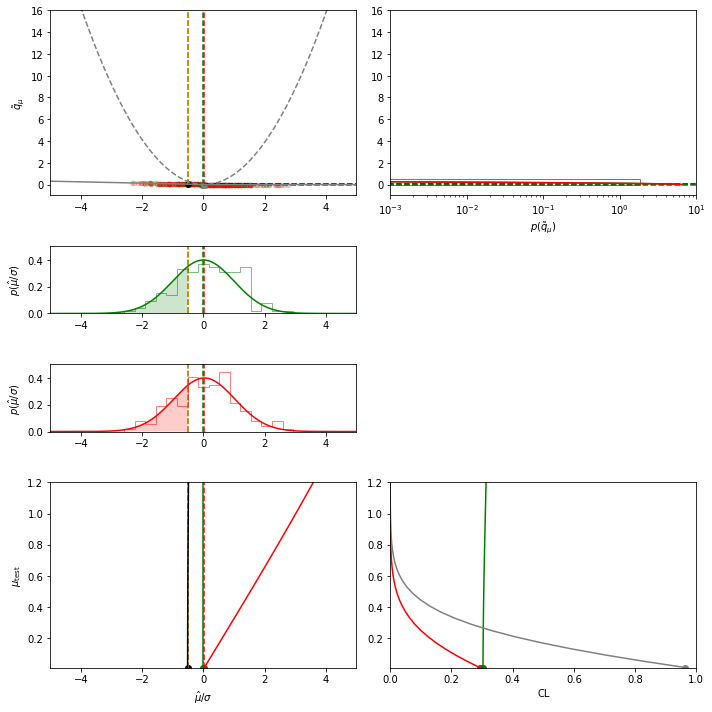

/Users/lukasheinrich/Code/neos/neosenv/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:334: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)


0.049666666666666665
0.03383660842503193 0.03822624385351043
0.3432945894510153 0.34597200645725895


/Users/lukasheinrich/Code/neos/neosenv/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


<Figure size 432x288 with 0 Axes>

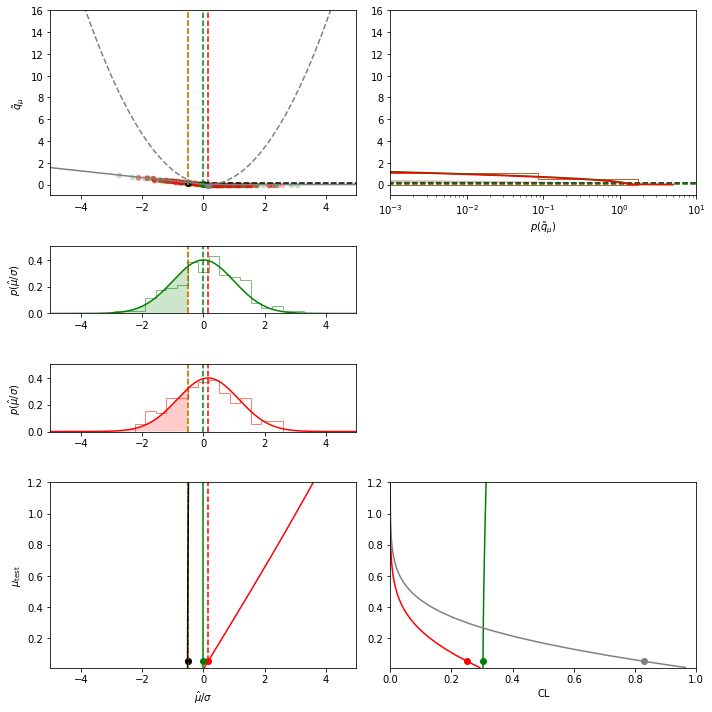

/Users/lukasheinrich/Code/neos/neosenv/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:334: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)


0.08933333333333332
0.07538265085616842 -0.06840032372812045
0.31767437914119234 0.3422635700187313


/Users/lukasheinrich/Code/neos/neosenv/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


<Figure size 432x288 with 0 Axes>

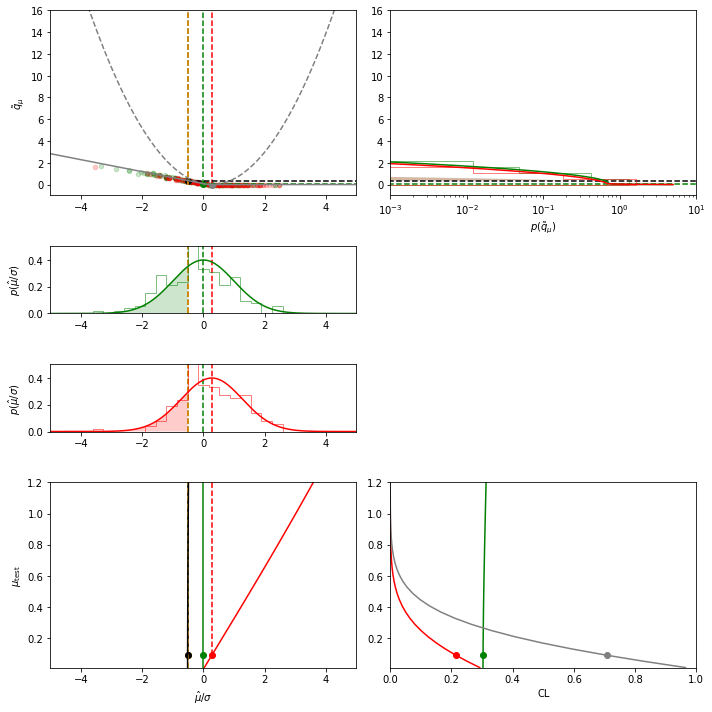

/Users/lukasheinrich/Code/neos/neosenv/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:334: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)


0.129
0.12308784406599114 -0.020989340529339883
0.30641674444735334 0.3648415944729559


/Users/lukasheinrich/Code/neos/neosenv/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


<Figure size 432x288 with 0 Axes>

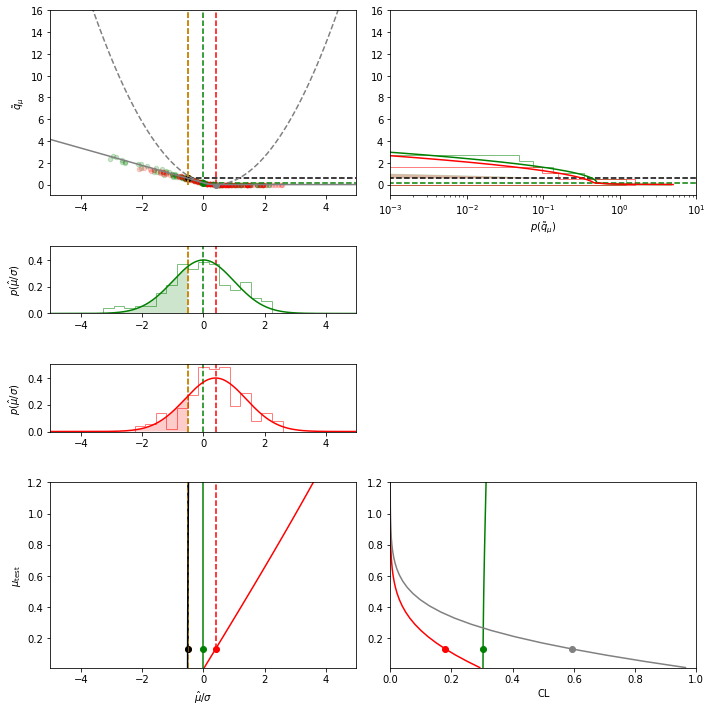

/Users/lukasheinrich/Code/neos/neosenv/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:334: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)


0.16866666666666666
0.14384459657163184 0.013266469081718083
0.32343611086131646 0.30859504661522025


/Users/lukasheinrich/Code/neos/neosenv/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


<Figure size 432x288 with 0 Axes>

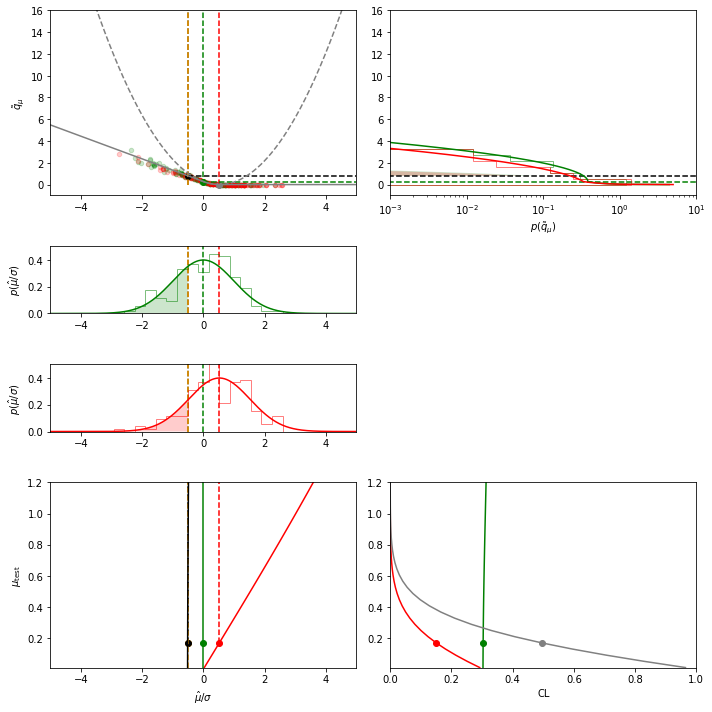

/Users/lukasheinrich/Code/neos/neosenv/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:334: RuntimeWarning: invalid value encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)


In [55]:
def plot_explanation(
    axarr,
    index,
    muhatspan,
    muspan,
    test_stats,
    vals,
):

    mutest_at_index = muspan[index]
    means_at_index = -test_stats[index, [1, 0]]
    ts_at_index = -test_stats[index, 2]
    vals_at_index = vals[index]

    tail_span = np.linspace(muhatmin, ts_at_index, 1001)

    obs_pllr_ts, asimov_pllr_ts, sigma = prll_and_sigmas[index]

    ###
    toys_bkg = model.make_pdf(pyhf.tensorlib.astensor([0.0, 1.0])).sample((150,))
    toys_sig = model.make_pdf(pyhf.tensorlib.astensor([mutest_at_index, 1.0])).sample(
        (150,)
    )
    muhat_s, qmu_tilde_s = get_toy_results(mutest_at_index, toys_sig)

    muhat_b, qmu_tilde_b = get_toy_results(mutest_at_index, toys_bkg)

    print(mutest_at_index)
    print(muhat_s.mean(), muhat_b.mean())
    print(muhat_s.std(), muhat_b.std())

    ###

    tsrail_parab = testrail_parab(muhatspan, mutest_at_index / sigma, sigma=1)
    tsrail_flat = testrail_flat(muhatspan, mutest_at_index / sigma, sigma=1)

    tail_span_qq = np.linspace(obs_pllr_ts, maxsigma ** 2, 1001)

    empirial_muhat_over_sigma = empirial_muhat / sigma

    muhat_pdfs = scipy.stats.norm(np.array(means_at_index)).pdf(
        np.tile(muhatspan.reshape(-1, 1), (1, 2))
    )

    muhat_pdfs_tail = scipy.stats.norm(np.array(means_at_index)).pdf(
        np.tile(tail_span.reshape(-1, 1), (1, 2))
    )

    ax = axarr['A']
    ax.set_ylabel(r'$\tilde{q}_\mu$')
    ax.set_xlim(muhatmin, muhatmax)

    ax.plot(muhatspan, tsrail_parab, c='grey', linestyle='dashed')
    ax.plot(muhatspan, tsrail_flat, c='grey')
    ax.vlines(0, 0, maxsigma ** 2, colors='green', linestyles='dashed')
    ax.vlines(means_at_index[1], 0, maxsigma ** 2, colors='red', linestyles='dashed')
    ax.vlines(ts_at_index, 0, maxsigma ** 2, colors='black', linestyles='dashed')
    ax.vlines(
        empirial_muhat_over_sigma,
        0,
        maxsigma ** 2,
        colors='orange',
        linestyles='dashed',
    )

    ax.scatter(muhat_b / sigma, qmu_tilde_b, alpha=0.2, c='green', s=20)
    ax.scatter(muhat_s / sigma, qmu_tilde_s, alpha=0.2, c='red', s=20)
    ax.scatter(0.0, asimov_pllr_ts, c='green')

    ax.hlines(asimov_pllr_ts, 0.0, muhatmax, colors='green', linestyles='dashed')

    ax.hlines(obs_pllr_ts, ts_at_index, muhatmax, colors='black', linestyles='dashed')
    ax.scatter(empirial_muhat_over_sigma, obs_pllr_ts, c='orange')
    ax.scatter(ts_at_index, obs_pllr_ts, c='black')
    ax.scatter(mutest_at_index / sigma, 0.0, c='grey')

    ax.set_ylim(-1, maxsigma ** 2)

    ax = axarr['B']
    ax.set_xlabel(r'$p(\tilde{q}_\mu)$')
    pqq_s = gpdf(qqspan, mutest_at_index, sigma, mutest_at_index)
    pqq_b = gpdf(qqspan, 0.0, sigma, mutest_at_index)

    ax.hist(
        qmu_tilde_b,
        bins=np.linspace(0.0, maxsigma ** 2, 30),
        density=True,
        histtype='step',
        edgecolor='green',
        alpha=0.5,
        orientation='horizontal',
    )
    ax.hist(
        qmu_tilde_s,
        bins=np.linspace(0.0, maxsigma ** 2, 30),
        density=True,
        histtype='step',
        edgecolor='red',
        alpha=0.5,
        orientation='horizontal',
    )

    pqq_s_tail = gpdf(tail_span_qq, mutest_at_index, 1.0, mutest_at_index)
    pqq_b_tail = gpdf(tail_span_qq, 0.0, 1.0, mutest_at_index)

    ax.plot(pqq_b, qqspan, c='green')
    ax.plot(pqq_s, qqspan, c='red')

    ax.fill_betweenx(tail_span_qq, pqq_b_tail, facecolor='green', alpha=0.2)
    ax.fill_betweenx(tail_span_qq, pqq_s_tail, facecolor='red', alpha=0.2)
    ax.set_xscale('log')

    ax.hlines(obs_pllr_ts, 0.0, 10.0, colors='black', linestyles='dashed')
    ax.hlines(asimov_pllr_ts, 0.0, 10.0, colors='green', linestyles='dashed')
    ax.set_xlim(1e-3, 1e1)
    ax.set_ylim(-1, maxsigma ** 2)

    ax = axarr['F']

    ax.set_ylabel(r'$p(\hat{\mu}/\sigma)$')
    ax.hist(
        muhat_b / sigma,
        bins=np.linspace(muhatmin, muhatmax, 30),
        density=True,
        histtype='step',
        edgecolor='green',
        alpha=0.5,
    )

    ax.plot(muhatspan, muhat_pdfs[:, 0], c='green')
    ax.fill_between(tail_span, muhat_pdfs_tail[:, 0], facecolor='green', alpha=0.2)

    ax.vlines(0, 0, 0.5, colors='green', linestyles='dashed')
    ax.vlines(means_at_index[1], 0, 0.5, colors='red', linestyles='dashed')
    ax.vlines(ts_at_index, 0, 0.5, colors='black', linestyles='dashed')
    ax.vlines(empirial_muhat_over_sigma, 0, 0.5, colors='orange', linestyles='dashed')
    ax.set_xlim(muhatmin, muhatmax)
    ax.set_ylim(0, 0.5)

    ax = axarr['C']
    ax.set_ylabel(r'$p(\hat{\mu}/\sigma)$')
    ax.hist(
        muhat_s / sigma,
        bins=np.linspace(muhatmin, muhatmax, 30),
        density=True,
        histtype='step',
        edgecolor='red',
        alpha=0.5,
    )

    ax.plot(muhatspan, muhat_pdfs[:, 1], c='red')
    ax.fill_between(tail_span, muhat_pdfs_tail[:, 1], facecolor='red', alpha=0.2)
    ax.vlines(0, 0, 0.5, colors='green', linestyles='dashed')
    ax.vlines(means_at_index[1], 0, 0.5, colors='red', linestyles='dashed')
    ax.vlines(ts_at_index, 0, 0.5, colors='black', linestyles='dashed')
    ax.vlines(empirial_muhat_over_sigma, 0, 0.5, colors='orange', linestyles='dashed')
    ax.set_xlim(muhatmin, muhatmax)
    ax.set_ylim(0, 0.5)

    ax = axarr['D']
    ax.set_ylabel(r'$\mu_\mathrm{test}$')
    ax.set_xlabel(r'$\hat{\mu}/\sigma$')

    ax.scatter(empirial_muhat_over_sigma, mutest_at_index, c='orange')
    ax.plot(-test_stats[:, 0], muspan, c='red')
    ax.plot(-test_stats[:, 1], muspan, c='green')
    ax.scatter(means_at_index[1], mutest_at_index, c='red')
    ax.vlines(means_at_index[1], mutest_at_index, 5, colors='red', linestyles='dashed')

    ax.plot(-test_stats[:, 2], muspan, c='black')
    ax.scatter(ts_at_index, mutest_at_index, c='black')
    ax.vlines(ts_at_index, mutest_at_index, mumax, colors='black', linestyles='dashed')
    ax.vlines(
        empirial_muhat_over_sigma, mumin, mumax, colors='orange', linestyles='dashed'
    )
    ax.hlines(
        empirial_muhat,
        empirial_muhat_over_sigma,
        muhatmax,
        colors='orange',
        linestyles='dashed',
    )

    ax.scatter(means_at_index[0], mutest_at_index, c='green')

    ax.set_xlim(muhatmin, muhatmax)
    ax.set_ylim(mumin, mumax)

    ax = axarr['E']
    ax.set_xlabel(r'CL')

    ax.plot(vals[:, 0], muspan, c='red')
    ax.plot(vals[:, 1], muspan, c='green')
    ax.plot(vals[:, 2], muspan, c='grey')

    ax.scatter(vals_at_index[0], mutest_at_index, c='red')
    ax.scatter(vals_at_index[1], mutest_at_index, c='green')
    ax.scatter(vals_at_index[2], mutest_at_index, c='grey')

    ax.hlines(empirial_muhat, 0, 1.0, colors='orange', linestyles='dashed')

    ax.set_ylim(mumin, mumax)
    ax.set_xlim(0, 1)


for index in range(len(muspan)):
    # for index in [15]:
    f, axarr = plt.subplot_mosaic(
        """
    AAABBB
    AAABBB
    FFF...
    CCC...
    DDDEEE
    DDDEEE
    """
    )

    plot_explanation(
        axarr,
        index,
        muhatspan,
        muspan,
        test_stats,
        vals,
    )

    f.set_tight_layout(True)
    f.set_size_inches(10, 10)
    f.savefig(f'scan{str(index).zfill(5)}.png')
    plt.show()
    plt.clf()

(0.0, 1.0)

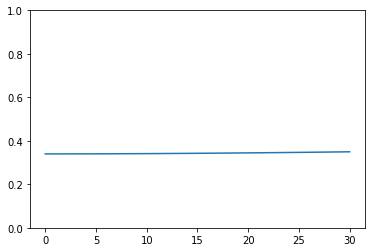

In [6]:
plt.plot(prll_and_sigmas[:, 2])
plt.ylim(0.0, 1)

In [13]:
import scipy.stats

scipy.stats.norm.ppf(0.05)

-1.6448536269514729

In [27]:
data_at_muhat = collect_data_at_test(empirial_muhat)
blevel = data_at_muhat[1][1]
sigma_at_muhat = data_at_muhat[-1][-1]
starget = 0.05 * blevel
starget_delta_in_muhat_over_sigma = abs(scipy.stats.norm.ppf(starget))
guessed_up = empirial_muhat + starget_delta_in_muhat_over_sigma * sigma_at_muhat

([-2.2813943561201224, 0.0, array(-0.48110263)],
 [array(0.03590729), array(0.68477822), array(0.05243638)],
 [array(3.24105028), array(5.20476021), 0.34435618554341557])